In [66]:
## general
import sys, glob
import numpy as np
import xarray as xr
import datetime as dt
import pandas as pd

## statistics
from scipy import stats 
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der
from statsmodels.stats.weightstats import DescrStatsW

## plotting
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore") 

In [7]:
import conditional_distributions

## Distributions

In [2]:
params = pd.read_csv('/home/peter/Projects/reversal_of_the_impact_chain/data/Berlin_daily_mean_tas_JJA/pN012.csv', index_col=0)

In [3]:
params.index.values

array(['ACCESS-CM2', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3',
       'GFDL-ESM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0'], dtype=object)

In [8]:
N = conditional_distributions.normal()

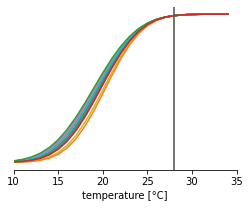

In [17]:
gmt = 0.86
xaxis = np.arange(5,35,1)
fig,ax = plt.subplots(figsize=(4,3))
for esm in params.index:
    ax.plot(xaxis, N.cdf(gmt, xaxis, params.loc[esm]))
    ax.axvline(x = N.ppf_for_gmts(np.array([gmt]), 0.99, params.loc[esm]), color='k', lw=0.1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('temperature [°C]')
_ = ax.set_xlim(10,35)

### Adjust ditributions to vicedo-cabrera et al
in their data, the 99th percentile for the period 1991-2018 is 27.5\
according to https://wlcalc.climateanalytics.org the GMT level of this period is 0.86

In [18]:
p99 = 28
gmt = 0.86
for esm in params.index:
    params.loc[esm].loc['loc_0'] += p99 - N.ppf_for_gmts(np.array([gmt]), 0.99, params.loc[esm])

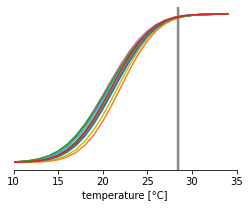

In [19]:
gmt = 1.2
xaxis = np.arange(5,35,1)
fig,ax = plt.subplots(figsize=(4,3))
for esm in params.index:
    ax.plot(xaxis, N.cdf(2, xaxis, params.loc[esm]))
    ax.axvline(x = N.ppf_for_gmts(np.array([gmt]), 0.99, params.loc[esm]), color='k', lw=0.1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('temperature [°C]')
_ = ax.set_xlim(10,35)

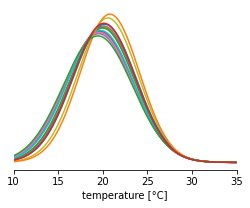

In [20]:
gmt = 1.2
xaxis = np.arange(5,35,0.1)
fig,ax = plt.subplots(figsize=(4,3))
for esm in params.index:
    ax.plot(xaxis, N.pdf(gmt, xaxis, params.loc[esm]))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('temperature [°C]')
_ = ax.set_xlim(10,35)

In [22]:
ensemble_wrapper = conditional_distributions.multi_params_wrapper(params)

## GMT and emissions - PROVIDE scenarios

In [44]:
emissions = pd.read_table('/home/peter/Projects/reversal_of_the_impact_chain/data/Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))

In [34]:
fair_gmt = xr.load_dataset('/home/peter/Projects/reversal_of_the_impact_chain/data/fair_temperatures_tier_2.nc')['gmt']
fair_gmt = fair_gmt.rename(run='fair_run')

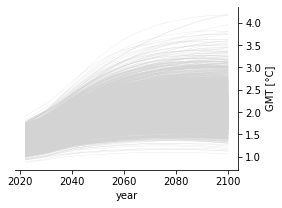

In [35]:
fig,ax = plt.subplots(figsize=(4,3))
scen = fair_gmt.scen.values[1400]
for fair_run in fair_gmt.fair_run.values:
    ax.plot(fair_gmt.year, fair_gmt.loc[scen,fair_run].values, color='lightgray', linewidth=0.2)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('GMT [°C]')
_ = ax.set_xlabel('year')

## GMT and emissions - CMIP6 ScenarioMIP scenarios

In [45]:
# CMIP6 scenarios FaiR
files = glob.glob('/home/peter/Projects/data/FaiR/AR6/temps/temperature_full_ens_*.csv')
scenarios = [f.split('_')[-1].split('.')[0] for f in files]

fair_gmt_cmip6 = xr.DataArray(dims=['scen','fair_run','year'], coords=dict(scen=scenarios, 
                                                                           fair_run=np.arange(1001), 
                                                                           year=np.arange(1750,2301,1,'int')))
for fl,scen in zip(files,scenarios):
    fair_gmt_cmip6.loc[scen] = pd.read_table(fl, sep=',', index_col=0).values.T

In [ ]:
# CMIP6 scenarios emissions
co2_cmip6 = pd.read_table('/home/peter/Projects/reversal_of_the_impact_chain/ssp_emissions_co2.csv', sep=';', decimal=',')
co2_cmip6 = co2_cmip6.loc[(co2_cmip6.Variable == 'CMIP6 Emissions|CO2')].iloc[:-1,:-1]
co2_cmip6 = xr.DataArray(co2_cmip6.iloc[:,5:].values, dims=['scen','year'], 
                         coords=dict(scen=co2_cmip6.Scenario, year=np.array(co2_cmip6.columns[5:], 'int')))

## number of summer days

In [38]:
def fraction_of_hot_summer_days_gmt(gmt, threshold):
    a = ensemble_wrapper.wrap(func = N.threshold_exceed_prob_vs_gmts, 
                                      threshold=threshold, 
                                      gmt=np.array([gmt]), 
                                      dim_names=['gmt'])
    return a


def fraction_of_hot_summer_days_ssp(scen, threshold, year):
    a = ensemble_wrapper.wrap(func = N.threshold_exceed_prob_vs_gmts, 
                                  threshold=threshold, 
                                  gmt=fair_gmt_cmip6.loc[scen.lower().replace('-',''),:,year].values.flatten(), 
                                  dim_names=['gmt'])
    return a.T

def fraction_of_hot_summer_days(threshold, year):
    prob = xr.DataArray(coords=dict(scen=fair_gmt.scen.values, fair_run=fair_gmt.fair_run.values, esm=params.index.values), 
                           dims=['scen','fair_run','esm'])
    for scen in prob.scen.values:
        a = ensemble_wrapper.wrap(func = N.threshold_exceed_prob_vs_gmts, 
                                  threshold=threshold, 
                                  gmt=fair_gmt.loc[scen,:,year].values.flatten(), 
                                  dim_names=['gmt'])
        prob.loc[scen,:,:] = a.T
    return prob

def rel_incr_as_perc(prob, ref):
    return (prob/ref-1) *100

In [82]:
def emission_range_prob_anchor(probs, anchor, emission, urange=[17,83]):
    # bin emission characterstic
    bins = np.linspace(emission.min(),emission.max(),100)

    v, w = np.array([]),np.array([])
    for lo,up in zip(bins[:-1], bins[1:]):
        # get scenarios that fall into the bin
        scens = cum_co2.scen.values[(emission >= lo) & (emission <= up)]
        if len(scens) > 0:
            # estimate KDE of probability of exceeding the threshold for these scenarios
            kde = stats.gaussian_kde(probs.loc[scens].values.flatten())
            # integrate over a small range around the selected probabilty
            w = np.append(w, kde.integrate_box_1d(anchor*0.95, anchor*1.05))
            v = np.append(v, np.mean([lo,up]))
    # calculate a weighted percentile 
    wq = DescrStatsW(data=v, weights=w)
    return wq.quantile(probs=np.array(urange)/100, return_pandas=False)

In [81]:
def gmt_range_prob_anchor(probs, anchor, urange=[17,83]):
    gmt = fair_gmt.loc[:,:,year]
    bins = np.linspace(gmt.min(),gmt.max(),100)
    v, w = np.array([]),np.array([])
    for lo,up in zip(bins[:-1], bins[1:]):
        sample = probs.values[(gmt >= lo) & (gmt <= up)].flatten()
        if len(sample) > 0:
            kde = stats.gaussian_kde(sample)
            w = np.append(w, kde.integrate_box_1d(anchor*0.95, anchor*1.05))
            v = np.append(v, np.mean([lo,up]))
    wq = DescrStatsW(data=v, weights=w)
    return wq.quantile(probs=np.array(urange)/100, return_pandas=False)

## Plotting

In [71]:
def plot_chain(ee, gg, pp, xs=[0,0,0], color='darkmagenta'):
    coords = []
    for ax,vals,x in zip([axE,axG,axP], [ee, gg,pp], xs):
        ax.fill_between([x-0.1,x+0.1], [vals[0]]*2, [vals[1]]*2, facecolor=color, edgecolor='none', zorder=1)
        coords = [fig.transFigure.inverted().transform(ax.transData.transform([x,vals[0]]))] + coords +\
                 [fig.transFigure.inverted().transform(ax.transData.transform([x,vals[1]]))]

    patch = matplotlib.patches.Polygon(coords, transform=fig.transFigure, edgecolor='none', facecolor=color, alpha=0.2)
    fig.patches.append(patch)
    

In [72]:
def prepare_axes():
    fig = plt.figure(figsize=(10,4), dpi=200)
    axE = fig.add_axes([0.3,0,0.2,0.8])
    axG = fig.add_axes([0.5,0,0.2,0.8])
    axP = fig.add_axes([0.7,0,0.2,0.8]) 

    for ax,title in zip([axE,axG,axP],['Emissions', 'Global Climate', 'Climate impact\ndriver','Socio-ecological\nimpact']):
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xticks([])
        ax.yaxis.tick_left()
        ax.yaxis.set_label_position("left")
        ax.patch.set_visible(False)
        ax.set_xlim(0,5.5)
    
    axE.set_ylim(0,2000)
    axG.set_yticks(np.arange(0,2000,500,'int'))
    axE.set_ylabel('cumulative CO2 emissions 2020-%s [Gt]' %(year))
    axG.set_ylim(1,2.5)
    axG.set_yticks([1,1.5,2,2.5])
    axG.set_ylabel('GMT above pre-industrial [K]')
    axP.set_ylim(1,4)
    axP.set_yticks(np.arange(0,200,50,'int'))
    axP.set_ylabel('relative increase in frequency of hot days\nwith expected health impacts [%]')

    return fig, axE, axG, axP

#fig, axE, axG, axP = prepare_axes()

In [73]:
year = 2050
threshold = 28
cum_co2_cmip6 = (co2_cmip6.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000
cum_co2 = (co2.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [74]:
ref_prob = fraction_of_hot_summer_days_gmt(1.2, threshold).squeeze()

In [75]:
rel_inc = rel_incr_as_perc(fraction_of_hot_summer_days(threshold, year), ref_prob)

In [83]:
anchor_reversal = 50
gmt_range = gmt_range_prob_anchor(rel_inc, anchor_reversal)
cum_co2_range = emission_range_prob_anchor(rel_inc, anchor_reversal, cum_co2)

Text(1.6, 50, '50%')

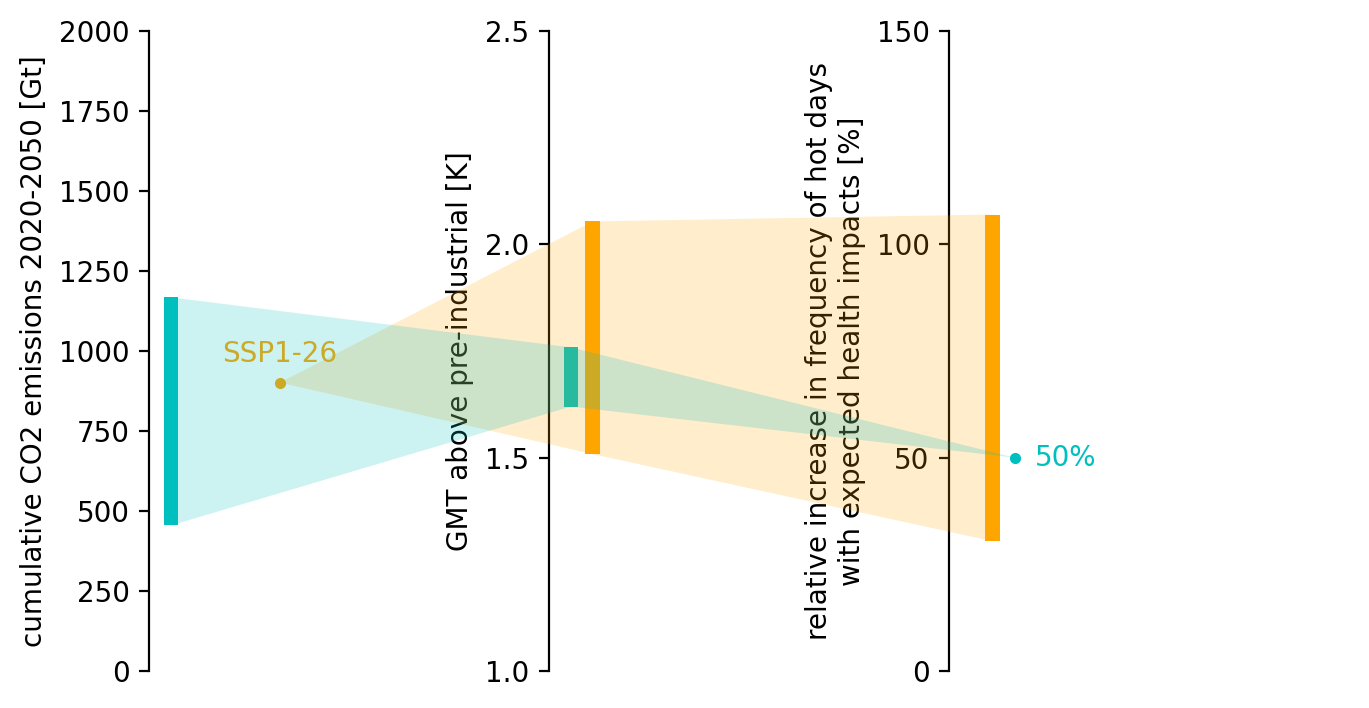

In [85]:
fig, axE, axG, axP = prepare_axes()

scen = 'SSP1-26'
anchor = float(cum_co2_cmip6.loc[scen].values)
pp = np.percentile(rel_incr_as_perc(fraction_of_hot_summer_days_ssp(scen, threshold, year),ref_prob), [17,83])
gg = np.percentile(fair_gmt_cmip6.loc[scen.lower().replace('-',''),:,year], [17,83])
plot_chain([anchor]*2, gg, pp, [1.8,0.6,0.6], 'orange')
axE.scatter(1.8, anchor, marker='.', color='orange')
axE.annotate(scen, xy=(1.8, anchor*1.05), color='orange', va='bottom', ha='center')

pp = [anchor_reversal] * 2 
plot_chain(cum_co2_range, gmt_range, pp, [0.3,0.3,0.9]*3, 'c')
axP.scatter(0.9, anchor_reversal, marker='.', color='c')
axP.annotate('%s' %(int(anchor_reversal)) + '%', xy=(1.6, 1*anchor_reversal), color='c', va='center', ha='center')

In [86]:
def cum_co2_limit(threshold, year, probability, confidence, fixed_reference_threshold=None):
    # fixed reference threshold
    if fixed_reference_threshold is None:
        fixed_reference_threshold = threshold
    # get prob of exceeding threshold in reference climate (GMT = 1.2)
    ref_prob = fraction_of_hot_summer_days_gmt(1.2, fixed_reference_threshold).squeeze()
    # get prob of exceeding threshold in given year
    prob = rel_incr_as_perc(fraction_of_hot_summer_days(threshold, year), ref_prob)
    # select scenarios for which the percentile corresponding to the confidence level is still below the specified probability
    scens = prob.scen[np.nanpercentile(prob, confidence, axis=(1,2)) < probability]
    if len(scens) > 0:
        # get cumulative CO2 emissions and select max from scenarios from above
        cum_co2 = (co2.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000
        cum_co2_limit = float(cum_co2.loc[scens].max())
        return [year, threshold, probability, confidence, cum_co2_limit]
    return [year, threshold, probability, confidence, np.nan]

In [87]:
limits = [
    [''] + cum_co2_limit(28, 2050, 50, 66, 28),
    ['higher confidence'] + cum_co2_limit(28, 2050, 50, 90, 28),
    ['assumed adaptation\nsame frequency'] + cum_co2_limit(29, 2050, 0, 90, 28),
    ['different year'] + cum_co2_limit(28, 2100, 50, 66, 28),
]

In [88]:
limits

[['', 2050, 28, 50, 66, 697.207941874441],
 ['higher confidence', 2050, 28, 50, 90, 315.11157318817766],
 ['assumed adaptation\nsame frequency', 2050, 29, 0, 90, 729.7568917995675],
 ['different year', 2100, 28, 50, 66, 881.894006408202]]

Text(-1250, 4.02, 'year')

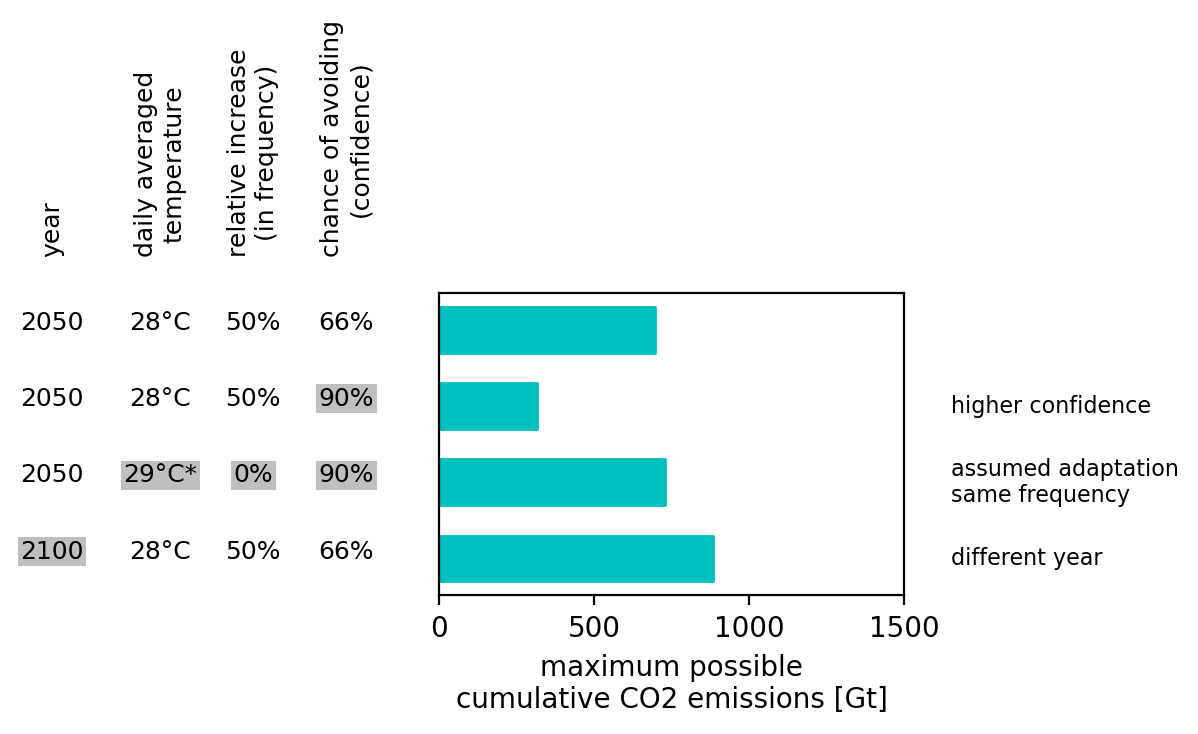

In [90]:
fig,ax = plt.subplots(nrows=1, figsize=(3,2), dpi=200)
ax.set_yticks([])
ax.set_xlim(0, 1500)#cum_co2.max())
#ax.axvline(0, color='k')
ax.set_xlabel('maximum possible\ncumulative CO2 emissions [Gt]')
bbox1 = dict(boxstyle='Square', pad=0.1, fc="gray", alpha=0, ec='none')
bbox2 = dict(boxstyle='Square', pad=0.1, fc="gray", alpha=0.5, ec='none')
bbox3 = dict(boxstyle='Square', pad=0.1, fc="gray", alpha=0.33, ec='none')
i=0
to = -300
for ll in limits[::-1]:
    name = ll[0]
    l = ll[1:]
    ax.annotate(str(int(l[0])), xy=(to-950, i), annotation_clip=False, ha='center', fontsize=9, bbox={2100:bbox2, 2050:bbox1}[l[0]])    
    ax.annotate(str(int(l[1]))+'°C'+{29:'*',28:''}[l[1]], xy=(to-600, i), annotation_clip=False, ha='center', fontsize=9, bbox={29:bbox2, 28:bbox1, 30:bbox2}[l[1]])    
    ax.annotate(str(int(l[2])) +'%', xy=(to-300, i), annotation_clip=False, ha='center', fontsize=9, bbox={50:bbox1, 0:bbox2, 100:bbox2}[l[2]])
    ax.annotate(str(int(l[3]))+'%', xy=(to, i), annotation_clip=False, ha='center', fontsize=9, bbox={66:bbox1, 90:bbox2}[l[3]])
    ax.annotate(name, xy=(1650, i), annotation_clip=False, fontsize=8, ha='left', va='center')
    if np.isnan(l[4]):
        ax.annotate(' unavoidable*', (0,i), ha='left', va='center')
    else:
        ax.fill_between([0,l[4]], [i-0.3]*2, [i+0.3]*2, color='c')
        
    i+=1
    
i_shift = 0.02
ax.annotate('chance of avoiding\n(confidence)', xy=(to, i+i_shift), rotation=90, annotation_clip=False, fontsize=9, ha='center')
ax.annotate('relative increase\n(in frequency)', xy=(to-300, i+i_shift), rotation=90, annotation_clip=False, fontsize=9, ha='center')
ax.annotate('daily averaged\ntemperature', xy=(to-600, i+i_shift), rotation=90, annotation_clip=False, fontsize=9, ha='center')
ax.annotate('year', xy=(to-950, i+i_shift), rotation=90, annotation_clip=False, fontsize=9, ha='center')
